In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df_orders = pd.read_csv("/content/olist_orders_dataset.csv")
# df_products = pd.read_csv("olist_products_dataset.csv")
# df_sellers = pd.read_csv("olist_sellers_dataset.csv")
# df_order_items = pd.read_csv("olist_order_items_dataset.csv")
df_order_payments = pd.read_csv("/content/olist_order_payments_dataset.csv")

# New Section

In [ ]:
print(df_order_payments.columns)
print(df_orders.columns)

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')


In [ ]:
df_payments = df_orders.merge(df_order_payments, on='order_id', how='inner')[['order_purchase_timestamp', 'payment_value']]
df_payments['order_purchase_timestamp'] = pd.to_datetime(df_payments['order_purchase_timestamp'])
df_payments['order_purchase_timestamp'] = df_payments['order_purchase_timestamp'].dt.strftime('%Y/%m/%d')
df_payments = df_payments.sort_values(by='order_purchase_timestamp', ascending=True)
df_payments = pd.DataFrame(df_payments.groupby('order_purchase_timestamp', as_index=False).agg(
    {'payment_value': 'sum'}))
mask = (df_payments['order_purchase_timestamp'] > '2017/01') & (df_payments['order_purchase_timestamp'] < '2018/08')
df_payments = df_payments.loc[mask]
df_payments['dow'] = pd.to_datetime(df_payments['order_purchase_timestamp']).apply(lambda x: x.dayofweek)
df_payments['moy'] = pd.to_datetime(df_payments['order_purchase_timestamp']).apply(lambda x: x.month)
df_payments['dom'] = pd.to_datetime(df_payments['order_purchase_timestamp']).apply(lambda x: x.day)

In [ ]:
new_df_payments = df_payments.groupby(df_payments.index // 1).sum()
weekly_data_df = df_payments.groupby(df_payments.index // 1).sum()

In [ ]:
new_df_payments

,payment_value,dow,moy,dom
14,707.27,3,1,5
15,988.28,4,1,6
16,1447.99,5,1,7
17,809.63,6,1,8
18,774.51,0,1,9
...,...,...,...,...
582,33331.12,4,7,27
583,30168.17,5,7,28
584,36468.26,6,7,29
585,46288.01,0,7,30


In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'full') / w
w = 1
values = new_df_payments['payment_value'].to_numpy()
dow = new_df_payments['dow'].to_numpy()
moy = new_df_payments['moy'].to_numpy()
dom = new_df_payments['dom'].to_numpy()

wom = [0]
last_month = moy[0]
for m, d in zip(moy[1:], dow[1:]):
    if m == last_month:
        if d != 0:
            wom.append(wom[-1])
        else:
            wom.append(wom[-1]+1)
    else:
        wom.append(0)
        last_month = m
wom = np.array(wom)

weekend = np.zeros(wom.shape)
weekend[np.where(dow == 5)] = 1
weekend[np.where(dow == 6)] = 1

In [ ]:
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf

(457, 4)
(457,)
[06:19:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2044872370656351
0.15743223789460312
0.18014520195692216
0.1418197144001249
0.3883084961331885
0.1655607438160339
0.22647775098340428
0.16463968195403517

(444, 10)
(444,)
[06:20:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.18987093280772294
0.13701215472810319
0.19152060194255172
0.17874526134779525
0.1795899281089819
0.1541088507755344
0.2075997437264141
0.20201456766249226

(430, 17)
(430,)
[06:21:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.19012547757081727
0.1201709599338379
0.18024013056146268
0.09650640039945894
0.23561696912888314
0.22042933937770925
0.24980745275867683
0.25197397123399073

(398, 33)
(398,)
[06:23:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linea

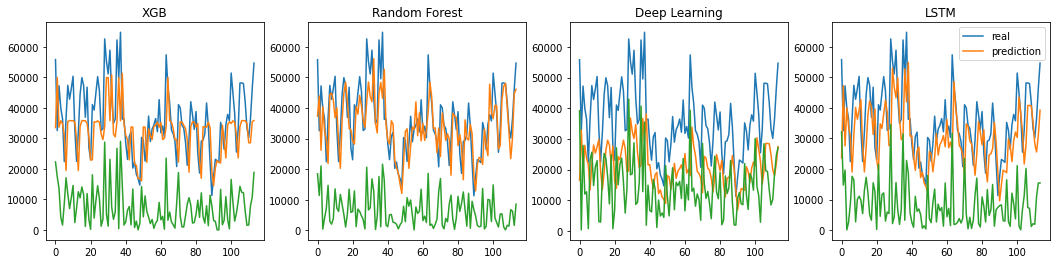

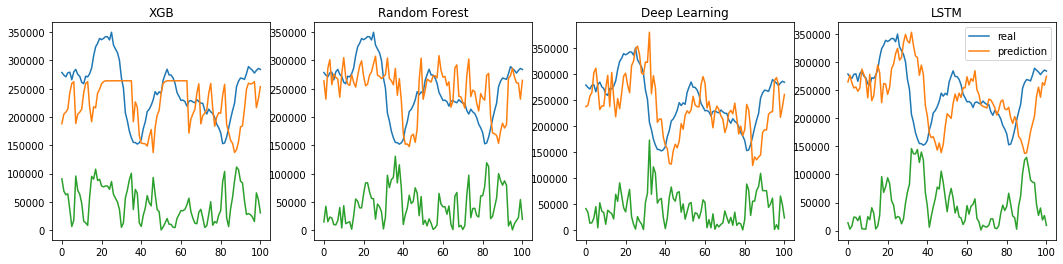

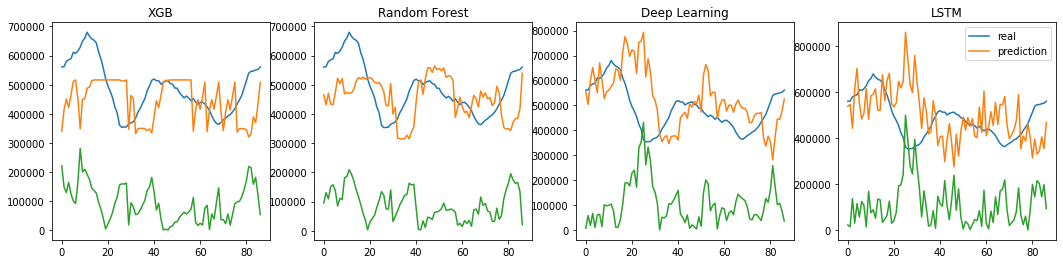

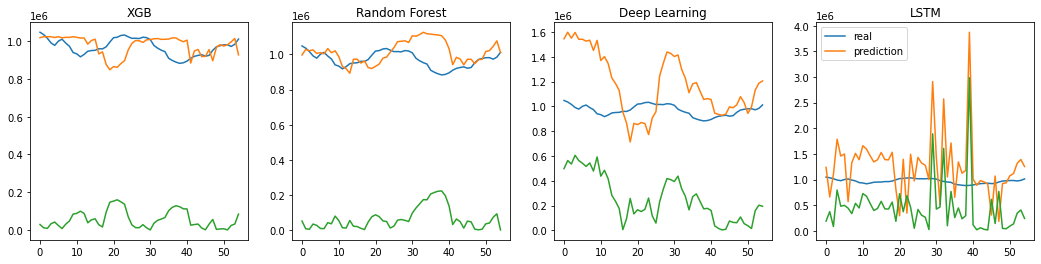

In [ ]:
def lstm_model(w, features):
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(w, features)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error')
    return model

def deep_learning(features):
    model = Sequential()
    model.add(Dense(8, input_shape=(features,), activation = 'relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer= tf.keras.optimizers.Adam(learning_rate = 0.01), metrics=['mse','mae'])
    return model

def format_data_for_lstm(x, w):
    data = x[:,:w]
    data = data.reshape((x.shape[0], w, 1))
    features = x[:,w:]
    features = features.reshape((features.shape[0], 1, features.shape[1]))
    features = np.repeat(features, w, axis=1)
    data = np.append(data, features, axis=2)
    return data


def train_and_test_xgb(w, train_input, train_output, test_input, test_output, **kwargs):
    model1 = xgboost.XGBRFRegressor(**kwargs)
    model2 = RandomForestRegressor()
    model3 = MLPRegressor(hidden_layer_sizes=(10,5,3), activation='identity', learning_rate='adaptive')
    model3 = deep_learning(train_input.shape[1])
    model4 = lstm_model(w, train_input.shape[1]-w+1)
    print(train_input.shape)
    print(train_output.shape)
    model1.fit(train_input, train_output)
    model2.fit(train_input, train_output)
    model3.fit(train_input, train_output, epochs=100, batch_size=1, verbose=0)
    lstm_train_input = format_data_for_lstm(train_input, w)
    model4.fit(lstm_train_input, train_output, epochs=50, verbose=0)
    

    xgb_pred = model1.predict(test_input)
    rf_pred = model2.predict(test_input)
    mlp_pred = model3.predict(test_input)
    mlp_pred = mlp_pred.reshape(mlp_pred.shape[0])
    lstm_test_input = format_data_for_lstm(test_input, w)
    lstm_pred = model4.predict(lstm_test_input)
    lstm_pred = lstm_pred.reshape(lstm_pred.shape[0])
    ma_pred = np.mean(test_input[:,:w], axis=1)

    fig, axs = plt.subplots(1, 4, figsize=(18,4))
    axs[0].plot(range(test_output.shape[0]), test_output, label='real')
    axs[0].plot(range(xgb_pred.shape[0]), xgb_pred, label='prediction')
    axs[0].plot(range(xgb_pred.shape[0]), (abs(test_output-xgb_pred)))
    axs[0].set_title("XGB")
    axs[1].plot(range(test_output.shape[0]), test_output, label='real')
    axs[1].plot(range(rf_pred.shape[0]), rf_pred, label='prediction')
    axs[1].plot(range(rf_pred.shape[0]), (abs(test_output-rf_pred)))
    axs[1].set_title("Random Forest")
    axs[2].plot(range(test_output.shape[0]), test_output, label='real')
    axs[2].plot(range(mlp_pred.shape[0]), mlp_pred, label='prediction')
    axs[2].plot(range(mlp_pred.shape[0]), (abs(test_output-mlp_pred)))
    axs[2].set_title("Deep Learning")
    axs[3].plot(range(test_output.shape[0]), test_output, label='real')
    axs[3].plot(range(lstm_pred.shape[0]), lstm_pred, label='prediction')
    axs[3].plot(range(lstm_pred.shape[0]), (abs(test_output-lstm_pred)))
    axs[3].set_title("LSTM")
    plt.legend()
    print(np.mean(abs(test_output-xgb_pred)/test_output))
    print(np.std(abs(test_output-xgb_pred)/test_output))
    print(np.mean(abs(test_output-rf_pred)/test_output))
    print(np.std(abs(test_output-rf_pred)/test_output))
    print(np.mean(abs(test_output-mlp_pred)/test_output))
    print(np.std(abs(test_output-mlp_pred)/test_output))
    print(np.mean(abs(test_output-lstm_pred)/test_output))
    print(np.std(abs(test_output-lstm_pred)/test_output))
    print()

def create_data_and_train_test_model(w, split, values, dow, wom, weekend, cumilative_forcast_days, **kwargs):
    train_split_values = values[:int(values.shape[0]*split)]
    train_split_dow = dow[:int(values.shape[0]*split)]
    train_split_wom = wom[:int(values.shape[0]*split)]
    train_split_weekend = weekend[:int(values.shape[0]*split)]

    test_split_values = values[int(values.shape[0]*split):]
    test_split_dow = dow[int(values.shape[0]*split):]
    test_split_wom = wom[int(wom.shape[0]*split):]
    test_split_weekend = weekend[int(wom.shape[0]*split):]

    def process_input(x,dow, wom, weekend, w):
        start = range(x.shape[0]-w)
        stop = range(w,x.shape[0])
        output = []
        for i, j in zip(start, stop):
            output.append(x[i:j])
        dow = dow[stop]
        wom = wom[stop]
        weekend = weekend[stop]
        output = np.array(output)
        output = np.append(output, dow.reshape(dow.shape[0],1), axis=1)
        output = np.append(output, wom.reshape(wom.shape[0],1), axis=1)
        output = np.append(output, weekend.reshape(weekend.shape[0],1), axis=1)
        return output

    # daily prediction
    oneday_train_input = process_input(
        train_split_values, train_split_dow,
        train_split_wom, train_split_weekend, w)
    oneday_test_input = process_input(
        test_split_values, test_split_dow,
        test_split_wom, test_split_weekend, w)
    oneday_train_output = train_split_values[w:]
    oneday_test_output = test_split_values[w:]


    if cumilative_forcast_days > 1:
        multi_day_train_input = oneday_train_input[:-cumilative_forcast_days]
        multi_day_test_input = oneday_test_input[:-cumilative_forcast_days]
        multi_day_train_output = np.zeros(oneday_train_output.shape[0]-cumilative_forcast_days)
        multi_day_test_output = np.zeros(oneday_test_output.shape[0]-cumilative_forcast_days)
        for i in range(cumilative_forcast_days):
            multi_day_train_output = multi_day_train_output + oneday_train_output[i:multi_day_train_output.shape[0]+i]
            multi_day_test_output = multi_day_test_output + oneday_test_output[i:multi_day_test_output.shape[0]+i]

        train_and_test_xgb(w, multi_day_train_input, multi_day_train_output,
                        multi_day_test_input, multi_day_test_output, **kwargs)
    else:
        train_and_test_xgb(w, oneday_train_input, oneday_train_output,
                        oneday_test_input, oneday_test_output, **kwargs)

create_data_and_train_test_model(1, 0.8, values, dow, wom, weekend, 1)
create_data_and_train_test_model(7, 0.8, values, dow, wom, weekend, 7)
create_data_and_train_test_model(14, 0.8, values, dow, wom, weekend, 14)
create_data_and_train_test_model(30, 0.8, values, dow, wom, weekend, 30)
